## Example of running DLGA on real PDE data (KdV equation)

In [1]:
import os
import sys
import torch
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from pathlib import Path

# Add project root to Python path
current_dir = os.path.dirname(os.path.abspath('__file__'))
kd_main_dir = os.path.abspath(os.path.join(current_dir, ".."))
sys.path.append(kd_main_dir)

from kd.dataset import load_kdv_equation
from kd.model.kd_dlga import KD_DLGA
from kd.viz.dlga_viz import *
from kd.viz.dlga_kdv import *
from kd.viz.equation_renderer import *

## 1. 加载并准备数据

In [2]:
kdv_data = load_kdv_equation()                      # 首先，我们调用一个辅助函数来加载预先生成好的KdV方程的解数据 kdv_data 对象中包含了时空坐标和对应的解
x, t, u = kdv_data.x, kdv_data.t, kdv_data.usol     # (可选) 将完整数据集解包到独立的变量中 x/t/u: 空间坐标数组/时间坐标数组/完整的解 u(x, t) 矩阵

X_train, y_train = kdv_data.sample(n_samples=1000)  # 从总数据集中随机抽取1000个样本点作为我们的训练数据

## 2. 模型训练

In [3]:
model = KD_DLGA(
    operators=['u', 'u_x', 'u_xx', 'u_xxx'],        # 定义方程发现的 候选算子库
    epi=0.1,                                        # 方程的“稀疏性”或“简洁度”惩罚项
    input_dim=2,                                    # 输入数据的维度，必须与 X_train 的列数匹配
    verbose=False,                                  # 是否在进化过程中打印出每一代新发现的最优解
    max_iter=500                                   # 内部神经网络的最大训练迭代次数
)

print("\nTraining DLGA model...")
model.fit(X_train, y_train) # 这个过程将首先训练一个深度神经网络来学习数据的内在模式，然后运行遗传算法来搜索方程的符号形式，整个过程可能需要几分钟


Training DLGA model...
===============train Net=================
iter_num: 500      loss: 0.00290017    loss_validate: 0.00389484


100%|██████████| 100/100 [00:08<00:00, 11.63it/s]


Final solution debug info:
Chromosome length: 3
Coefficient shape: (3, 1)
Chromosome: [[0, 1], [3], [1, 2]]
Coefficients: [[-0.79700682]
 [-0.00186562]
 [-0.0010468 ]]
equation form: u_t=-0.797*u*u_x-0.0019*u_xxx-0.001*u_x*u_xx

[Equation Renderer INFO] Successfully received data from DLGA:

[Equation Renderer INFO] (Note: Using dynamic operator list for translation: ['u', 'u_x', 'u_xx', 'u_xxx'])
  Original chromosome (list of modules, a module is a list of gene indices):
    Term 1 - Module (gene indices): [0, 1]
      Meaning (product of terms): u * ux
    Term 2 - Module (gene indices): [3]
      Meaning (product of terms): uxxx
    Term 3 - Module (gene indices): [1, 2]
      Meaning (product of terms): ux * uxx
  Coefficients (NumPy array, corresponding to each module/term in the chromosome):
    Term 1 - Coefficient: -0.7970
    Term 2 - Coefficient: -0.0019
    Term 3 - Coefficient: -0.0010
  Left-hand side term name (string): u_t
  (Note: Gene indices in the chromosome map to

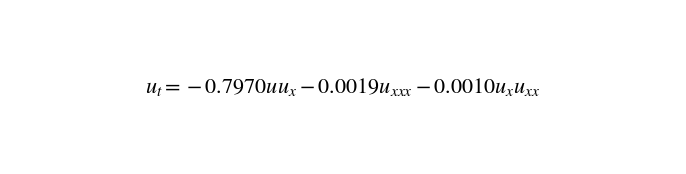

In [4]:
render_latex_to_image(model.eq_latex) # 模型在训练结束后，会将其发现的最佳方程以 LaTeX 格式存储在 model.eq_latex 中

## 3. 模型预测

In [5]:
print("\nGenerating predictions...")
# TODO 封装一下, model.predict(kdv_data) 
# Create full grid for visualization
X_full = kdv_data.mesh()
# Convert to tensor and predict
X_tensor = torch.from_numpy(X_full.astype(np.float32)).to(model.device)
with torch.no_grad():
    u_pred = model.Net(X_tensor).cpu().numpy().reshape(u.shape)

# 1. 将Numpy数组转换为PyTorch Tensor
# 2. 将数据传输到正确的计算设备（CPU/GPU）
# 3. 在无梯度的模式下（torch.no_grad()）进行高效推理
# 4. 将神经网络的输出结果转回Numpy数组，并调整为与原始解 u 相同的维度 得到的 u_pred 是模型在整个网格上的预测解


Generating predictions...


## 4. 可视化

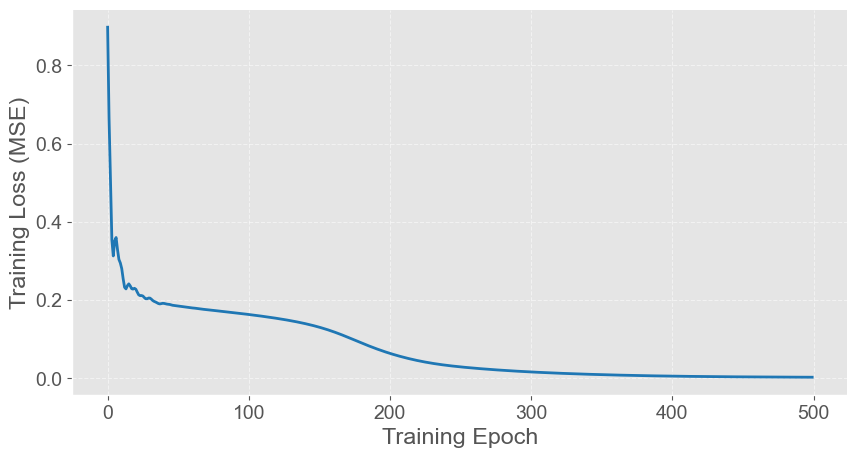

In [6]:
plot_training_loss(model) # 绘制神经网络的 训练损失 曲线

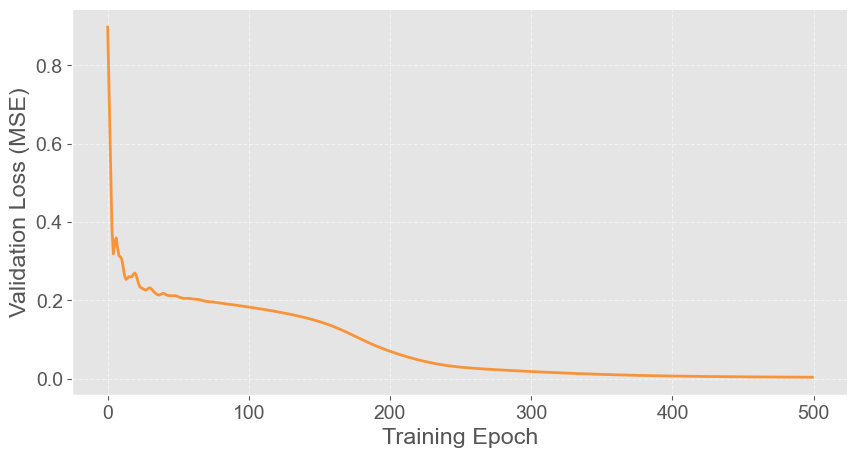

In [7]:
plot_validation_loss(model) # 绘制 验证损失 曲线

#### 遗传算法可视化

此图表由两个子图构成，分别从种群多样性和适应度收敛性两个维度，对遗传算法（GA）的优化过程进行量化分析

左图：种群多样性分析 (Population Diversity Analysis)
此图监测了种群规模（Population Size）与独特基因模块数量（Unique Modules）的动态关系。维持较高的独特模块数量是保证算法全局搜索能力、避免过早收敛（Premature Convergence）到局部最优解的关键

右图：适应度收敛分析 (Fitness Convergence Analysis)
此图展示了最优适应度（Fitness）随进化代数的收敛趋势。图中高亮部分标示了适应度值下降最显著的区间，可用于评估算法的收敛效率，并为设定合理的总进化代数提供依据

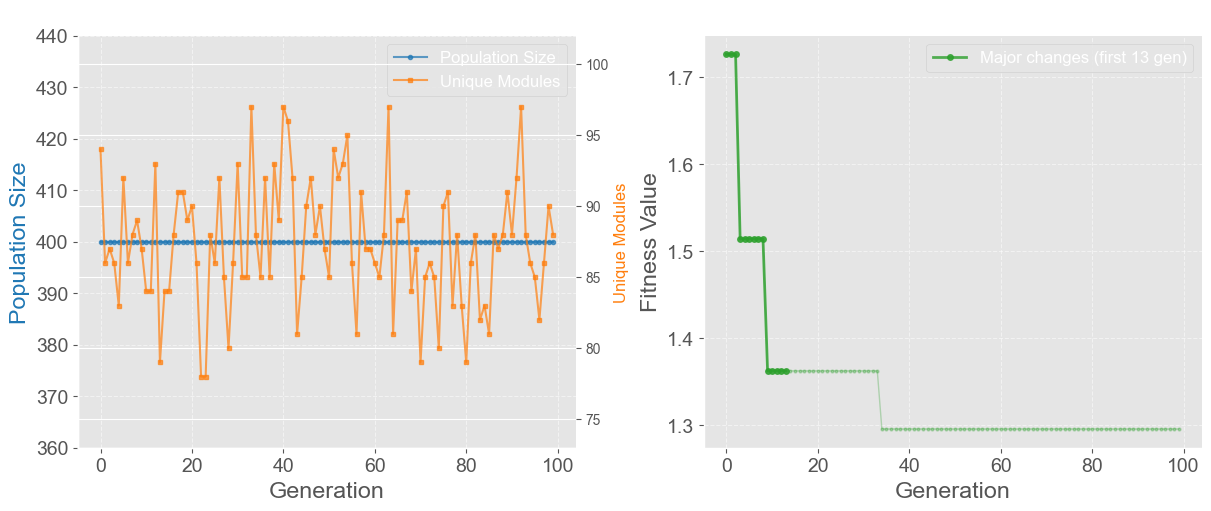


Optimization Analysis Summary:
Initial fitness: 1.7262
Final fitness: 1.2958
Major improvements occurred in first 13 generations
Improvement in major change period: 21.07%
Total improvement: 24.93%
Average population size: 400.0
Average unique modules: 87.4
Diversity ratio: 21.84%


In [8]:
plot_optimization_analysis(model)

绘制最优解的适应度（Fitness）见左图, 与复杂度（Complexity）见右图 随代数进化的曲线

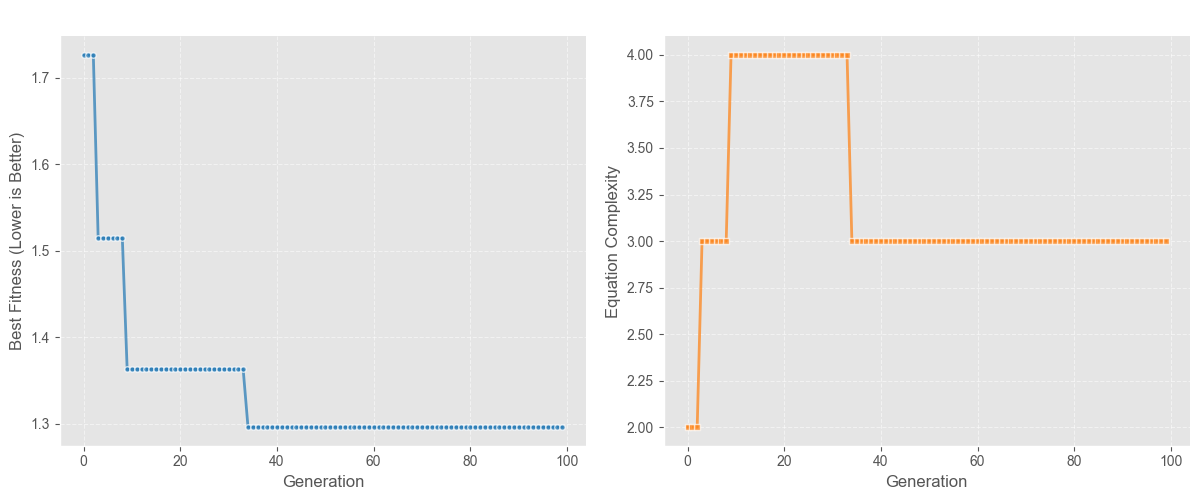


Evolution Analysis Summary:
Initial fitness: 1.7262
Final fitness: 1.2958
Improvement: 24.93%
Initial complexity: 2
Final complexity: 3


In [9]:
plot_evolution(model)

### 2. Solution Analysis
#### 2.1 PDE Solution Comparison


测试 plot_pde_comparison 函数...


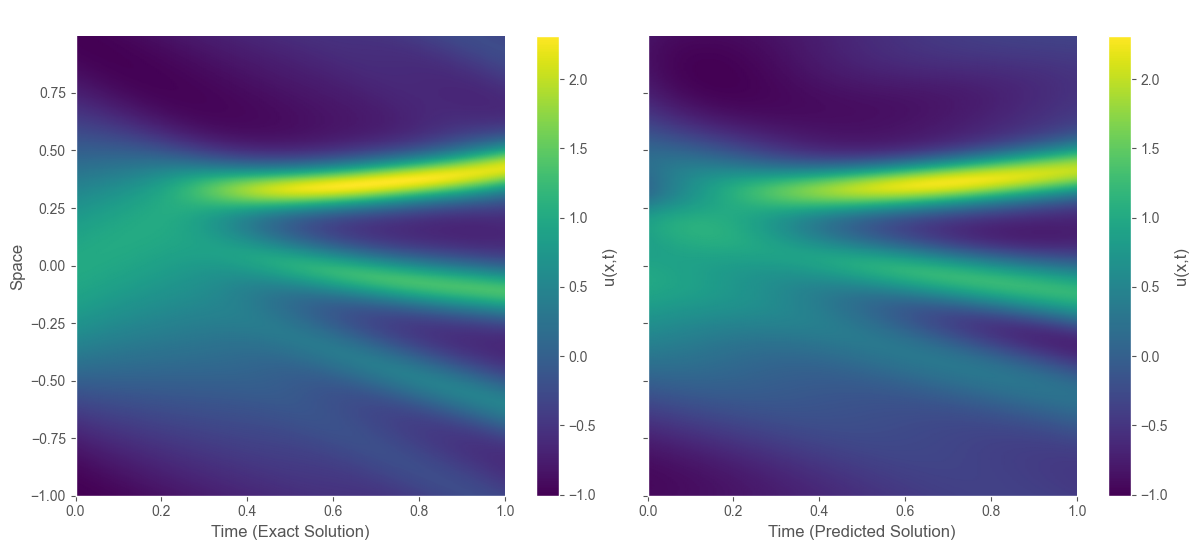

In [10]:
plot_pde_comparison(
    x=x,
    t=t,
    u_true=u,
    u_pred=u_pred
)

#### 2.2 Residual Analysis

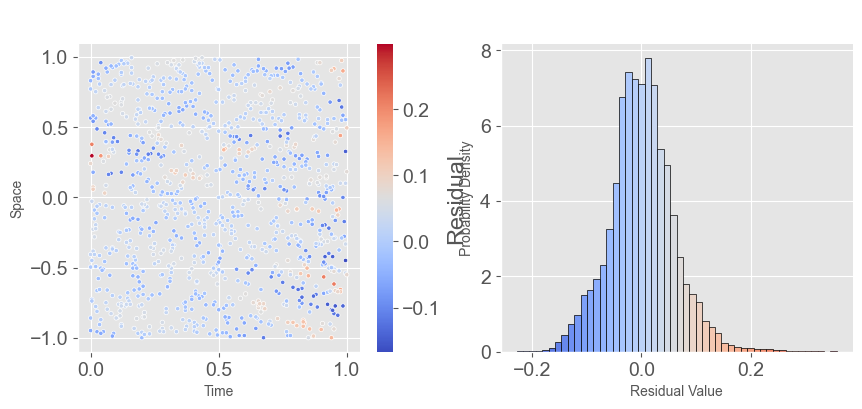

In [11]:
plot_residual_analysis(
    model=model,
    X_train=X_train,
    y_train=y_train,
    u_true=u,
    u_pred=u_pred,
)

#### 2.3 Time Slice Comparison

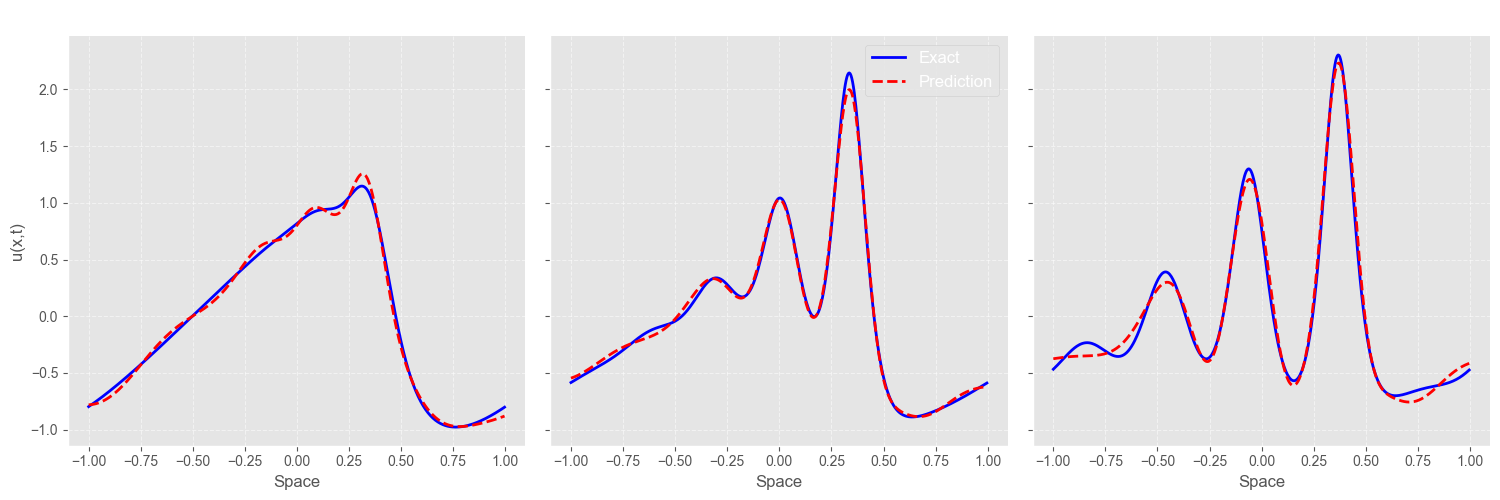

In [12]:
plot_time_slices(
    x=x,
    t=t,
    u_true=u,
    u_pred=u_pred,
    slice_times=[0.25, 0.5, 0.75]
)

### 3. Equation Discovery Analysis
#### 3.1 Term Relationship Plot

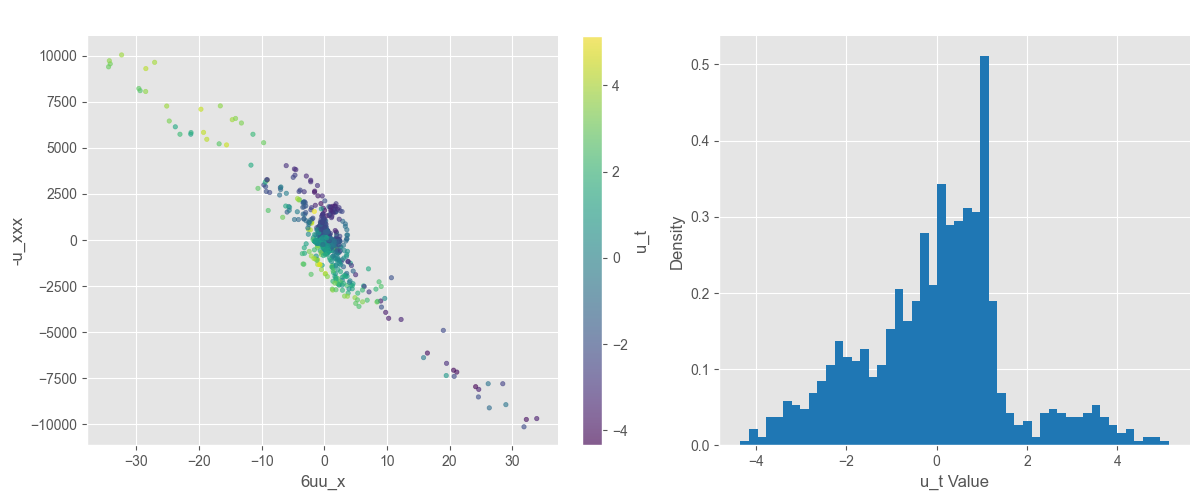

In [13]:
plot_equation_terms(
    model.metadata,
    terms={
        'x_term': {'vars': ['u', 'u_x'], 'label': '6uu_x'},
        'y_term': {'vars': ['u_xxx'], 'label': '-u_xxx'}
    },
    equation_name="KdV Equation",
)

#### 3.2 Metadata Plane Visualization (equation residuals on the x-t plane)


Interpolation info:
Source points shape: (961, 2)
Target grid shape: T=(512, 201), X=(512, 201)
Values shape: u_t=(961,), u=(961,)


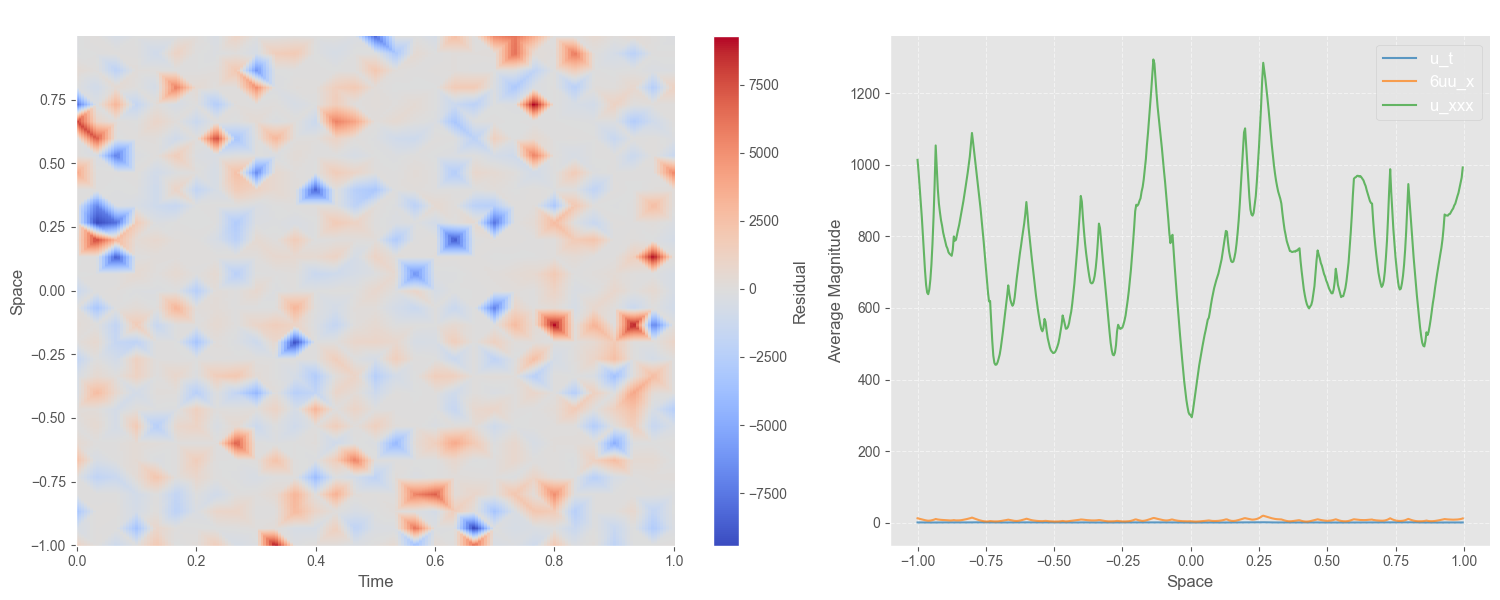


Metadata Plane Analysis:
Residual statistics:
  Mean: 1.6841e+01
  Std:  1.3072e+03
  Max:  9.4305e+03

Term magnitude statistics:
  u_t: 8.9457e-01
  6uu_x: 7.1081e+00
  u_xxx: 7.5089e+02


In [14]:
plot_metadata_plane(metadata=model.metadata, x=x, t=t)

#### 3.3 Derivative Relationships Visualization

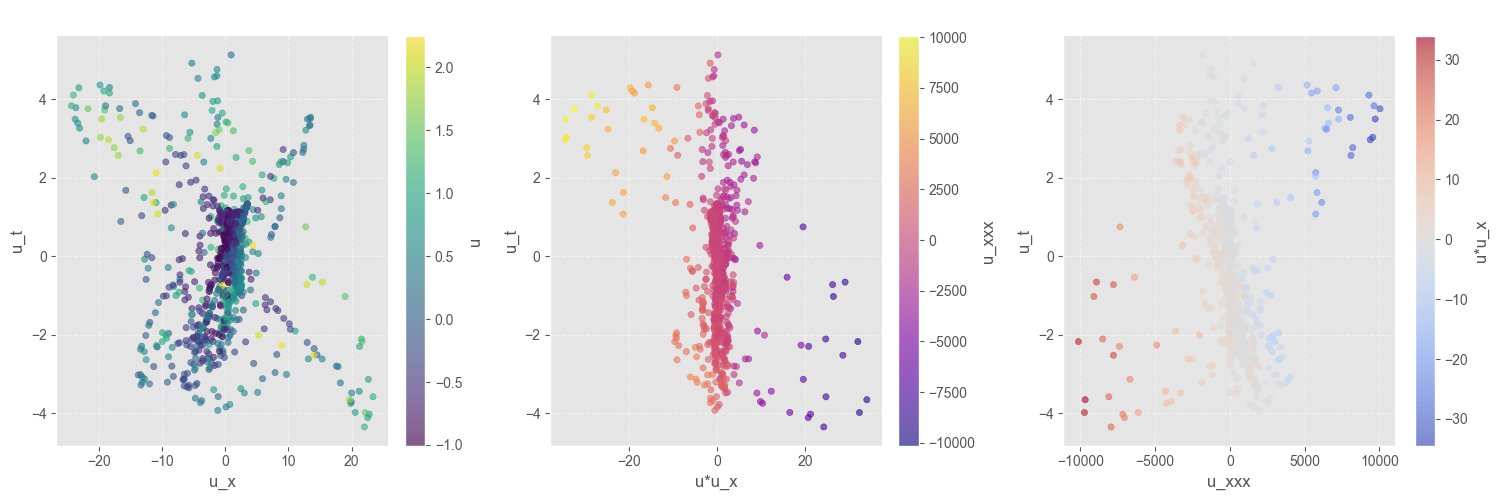

In [15]:
plot_derivative_relationships(metadata=model.metadata)